In [ ]:
!pip install tensorflow-io==0.25.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.4 MB 10.4 MB/s 
     |████████████████████████████████| 2.1 MB 15.9 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.27.0
    Uninstalling tensorflow-io-gcs-filesystem-0.27.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.27.0


In [ ]:
import tensorflow_io as tfio

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/MyDrive/ml/ml_data/sanzida/Tests/scream/416536__tonsil5__male-scream-2.wav',sr=None)
sr

44100

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/MyDrive/ml/ml_data/sanzida/Test2/scream/416536__tonsil5__male-scream-2.wav',sr=None)
sr

16000

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models

import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython import display

In [ ]:
data_dir = "/content/drive/MyDrive/ml/ml_data/sanzida/Test2/"
dir_list = [directory for directory in os.listdir(data_dir) if os.path.isdir(data_dir+directory)]
print(dir_list)

['scream', 'non_scream']


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print(commands[0])

scream


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir+commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 663
Number of examples per label: 447
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/ml/ml_data/sanzida/Test2/scream/222533__alberttrepat__male-screaming-out-loud.wav', shape=(), dtype=string)


In [ ]:
train_len = int(num_samples * 0.8)
test_len = int(math.ceil(num_samples * 0.1))
val_len = num_samples - (train_len+test_len)

print(train_len, test_len, val_len)

530 67 66


In [ ]:
train_files = filenames[:train_len]
val_files = filenames[train_len: train_len + test_len]
test_files = filenames[-val_len:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 530
Validation set size 67
Test set size 66


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_samples=16000)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
type(waveform_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

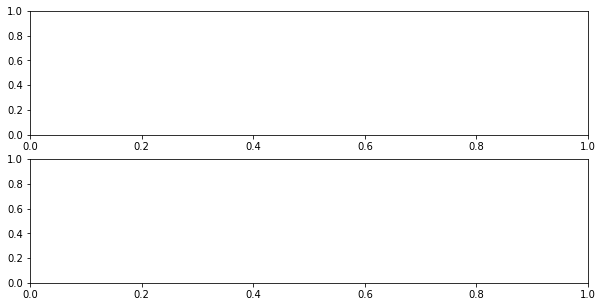

In [ ]:
rows = 1
cols = 2
n = rows*cols
fig, axes = plt.subplots(cols, figsize=(10, 5))
axes[0]

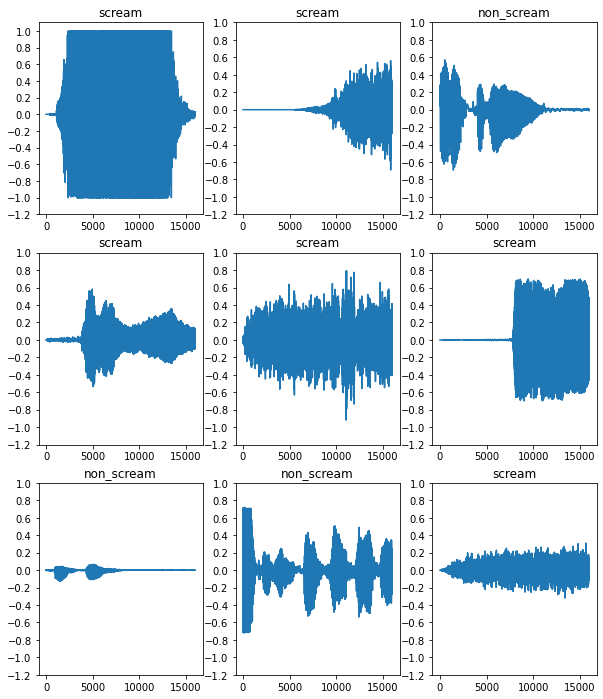

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  # Change sample rate
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  print(tf.shape(waveform))
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

tf.Tensor([16000], shape=(1,), dtype=int32)
Label: scream
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


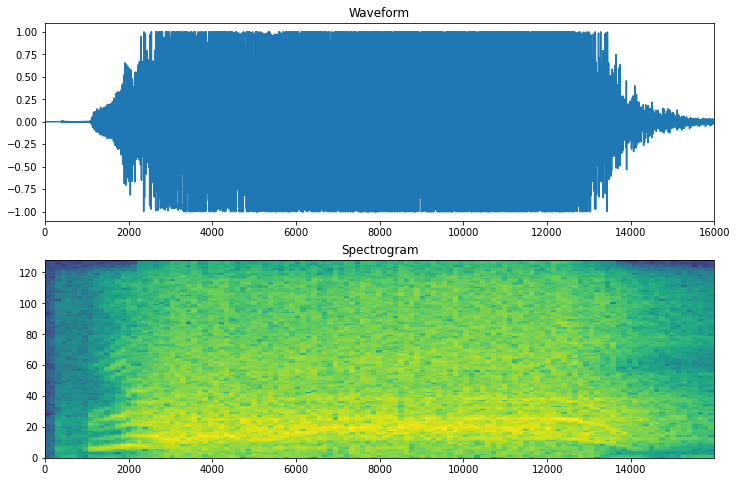

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

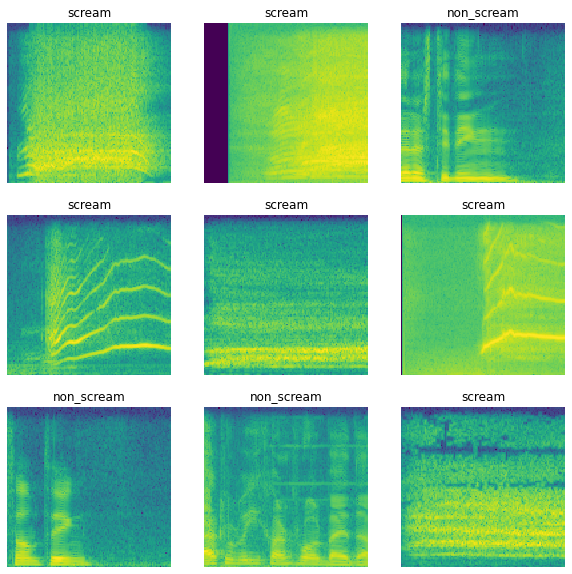

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print('Input shape: {} and len of labels {}'.format(input_shape, num_labels))

s_ds = spectrogram_ds.map(lambda x, _: x)
norm_layer = preprocessing.Normalization()

Input shape: (124, 129, 1)
Input shape: (124, 129, 1) and len of labels 2


In [ ]:
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     preprocessing.Resizing(32, 32), 
#     norm_layer,
#     layers.Conv2D(16, 3, activation='LeakyReLU'),
#     layers.MaxPool2D(),
#     layers.Conv2D(32, 3, activation='LeakyReLU'),
#     layers.MaxPool2D(),
#     layers.Conv2D(64, 3, activation='LeakyReLU'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='LeakyReLU'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels,activation="tanh"),
# ])

# model.summary()

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(16, 3, activation='LeakyReLU'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, activation='LeakyReLU'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='LeakyReLU'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='LeakyReLU'),
    layers.Dropout(0.5),
    layers.Dense(num_labels,activation="tanh"),
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_44 (Conv2D)          (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 6, 6, 32)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
9/9 [==============================] - 4s 338ms/step - loss: 0.5495 - accuracy: 0.6491 - val_loss: 0.4818 - val_accuracy: 0.7313
Epoch 2/20
9/9 [==============================] - 3s 355ms/step - loss: 0.5090 - accuracy: 0.7245 - val_loss: 0.4678 - val_accuracy: 0.7313
Epoch 3/20
9/9 [==============================] - 3s 331ms/step - loss: 0.4843 - accuracy: 0.7566 - val_loss: 0.4590 - val_accuracy: 0.7463
Epoch 4/20
9/9 [==============================] - 3s 303ms/step - loss: 0.4662 - accuracy: 0.7849 - val_loss: 0.4484 - val_accuracy: 0.7612
Epoch 5/20
9/9 [==============================] - 3s 296ms/step - loss: 0.4564 - accuracy: 0.7792 - val_loss: 0.4395 - val_accuracy: 0.7612
Epoch 6/20
9/9 [==============================] - 3s 285ms/step - loss: 0.4440 - accuracy: 0.7868 - val_loss: 0.4244 - val_accuracy: 0.7910
Epoch 7/20
9/9 [==============================] - 3s 304ms/step - loss: 0.4282 - accuracy: 0.8000 - val_loss: 0.4252 - val_accuracy: 0.7761
Epoch 8/20
9/9 [====

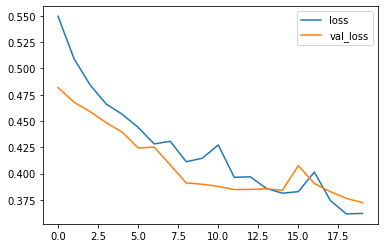

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 9ms/step
Test set accuracy: 80%


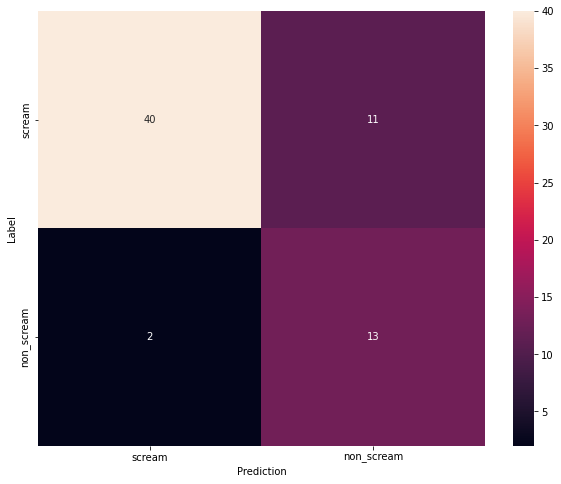

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
MODEL_FILE_NAME = "my_model.h5"
model.save(MODEL_FILE_NAME)
TF_LITE_MODEL_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_NAME
open(tflite_model_name, "wb").write(tflite_model)

230088